# Capstone Project - FourthBrain

# Optical Coherence Tomography (Samsung OCT) Project

In [1]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import math

In [2]:
#authorizing access to google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#delete folder when needed

%rm -rf '/content/OCT2017/'

In [ ]:
#!cp -av '/content/drive/My Drive/FourthBrain/Capstone_Project/OCT2017 /' -d '/content/OCT2017/'

In [6]:
!cp -r '/content/drive/My Drive/FourthBrain/Capstone_Project/OCT2017 /' '/content/OCT2017/'

In [ ]:
#!unzip "/content/drive/My Drive/FourthBrain/Capstone_Project/archive.zip" -d "/content/drive/My Drive/FourthBrain/Capstone_Project/"

In [ ]:
#%load_ext tensorboard

In [9]:
!nvidia-smi

Sun May  8 14:34:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
#directories

main_dir = '/content/OCT2017/'

train_dir = os.path.join(main_dir, 'train/')
train = os.listdir(train_dir)
val_dir = os.path.join(main_dir, 'val/')
val = os.listdir(val_dir)
test_dir = os.path.join(main_dir, 'test/')
test = os.listdir(test_dir)

In [8]:
#data set sizes

folders = [train_dir, val_dir, test_dir]

folder_names = {'Train': train_dir, 
           'Val': val_dir, 
           'Test': test_dir}

for folder, folder_name in zip(folders, folder_names):
    print('{} dataset: {} images'.format(folder_name, len(os.listdir(os.path.join(folder, 'CNV'))) + len(os.listdir(os.path.join(folder, 'DME'))) + 
          len(os.listdir(os.path.join(folder, 'DRUSEN'))) + len(os.listdir(os.path.join(folder, 'NORMAL')))))

Train dataset: 83484 images
Val dataset: 32 images
Test dataset: 968 images


In [10]:
#labels

train_labels=os.listdir(train_dir)

print('Labels: ', train_labels)

Labels:  ['DME', 'CNV', 'NORMAL', 'DRUSEN']


In [11]:
#label distribution in train dataset

labels =  ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for label in labels:
  print('{}: {}'.format(label, len(os.listdir(os.path.join(train_dir, label)))))

CNV: 37205
DME: 11348
DRUSEN: 8616
NORMAL: 26315


Normal


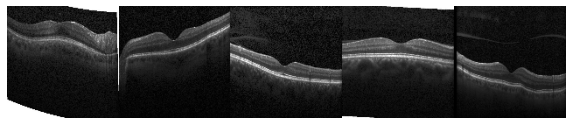

In [12]:
import glob

normalImages = glob.glob('/content/OCT2017/train/NORMAL/**')
cnvImages = glob.glob('/content/OCT2017/train/CNV/**')
dmeImages = glob.glob('/content/train/NORMAL/**')
drusenImages = glob.glob('/content/OCT2017/train/DRUSEN/**')

print("Normal")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in normalImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

CNV


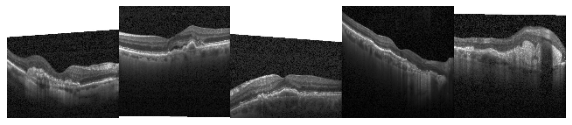

In [13]:
print("CNV")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in cnvImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

In [14]:
print("DME")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in dmeImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

DME


<Figure size 720x720 with 0 Axes>

DRUSEN


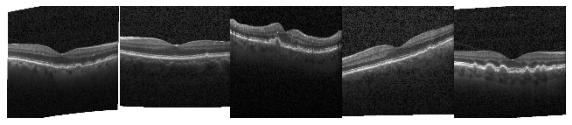

In [15]:
print("DRUSEN")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in drusenImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

# Data Preprocessing

In [16]:
#ImageDataGenerator

#train_datagen = ImageDataGenerator(validation_split=0.2)

#test_datagen = ImageDataGenerator()

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        #subset='training',   
        class_mode='categorical')
        
val_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        #subset='validation',
        class_mode='categorical')
        
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


# Model Architecture

Inspiration: https://keras.io/guides/transfer_learning/

Instantiating the pre-trained model.

In [17]:
pretrained_model= tf.keras.applications.Xception(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
    )

pretrained_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

Ensuring that pre-trained model will not learn the weights again.

In [18]:
pretrained_model.trainable = False

Using random data augmentation.

In [ ]:
#data_augmentation = tf.keras.Sequential(
#    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.2),]
#)
#
#inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

Base model.

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = pretrained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x - tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                             

In [ ]:
#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#earlystop = tf.keras.callbacks.EarlyStopping(
#    monitor='val_accuracy',
#    min_delta=0.01,
#    patience=10,
#    restore_best_weights=True
#)

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/My Drive/FourthBrain/Capstone_Project/xception_model_512n05.h5',
    #monitor='val_accuracy',
    mode='max', 
    save_best_only=True
)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [22]:
#initial_learning_rate = 0.01

#def lr_exp_decay(epoch, lr):
#    k = 0.1
#    return initial_learning_rate * math.exp(-k*epoch)

In [23]:
history = model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=100,
                           steps_per_epoch=(83484/32),
                           validation_steps=(968/32),
                           #callbacks=[earlystop, tensorboard_callback, tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)]
                           #callbacks=[earlystop, tensorboard_callback]
                           callbacks=[checkpoint]
                           )

Epoch 1/100
2608/2608 [==============================] - 384s 142ms/step - loss: 0.4650 - accuracy: 0.8294 - val_loss: 0.3494 - val_accuracy: 0.8295
Epoch 2/100
2608/2608 [==============================] - 355s 136ms/step - loss: 0.3812 - accuracy: 0.8610 - val_loss: 0.1772 - val_accuracy: 0.9432
Epoch 3/100
2608/2608 [==============================] - 354s 136ms/step - loss: 0.3498 - accuracy: 0.8737 - val_loss: 0.1801 - val_accuracy: 0.9308
Epoch 4/100
2608/2608 [==============================] - 353s 135ms/step - loss: 0.3217 - accuracy: 0.8827 - val_loss: 0.2140 - val_accuracy: 0.9225
Epoch 5/100
2608/2608 [==============================] - 354s 136ms/step - loss: 0.3022 - accuracy: 0.8906 - val_loss: 0.1891 - val_accuracy: 0.9277
Epoch 6/100
2608/2608 [==============================] - 354s 136ms/step - loss: 0.2828 - accuracy: 0.8968 - val_loss: 0.1935 - val_accuracy: 0.9153
Epoch 7/100
2608/2608 [==============================] - 355s 136ms/step - loss: 0.2647 - accuracy: 0.9042

In [24]:
#%tensorboard --logdir logs

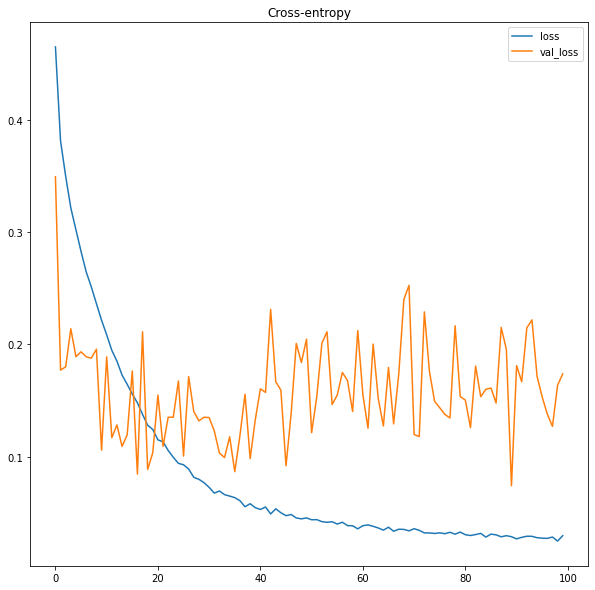

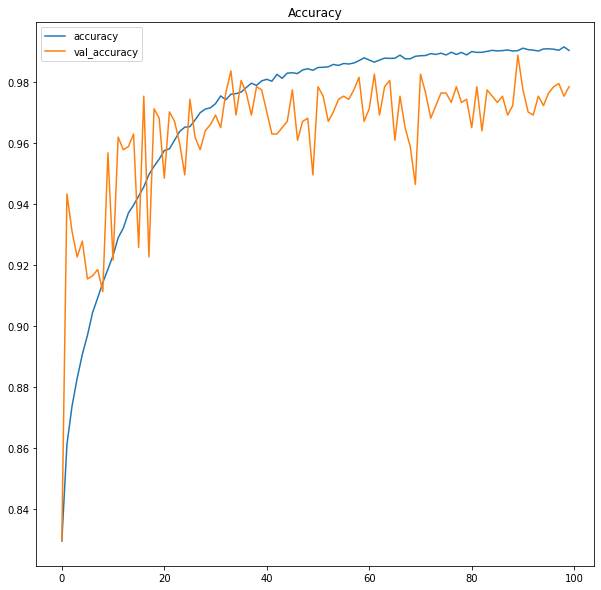

In [25]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [26]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

In [27]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

In [28]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      0.95      0.97       242
      DRUSEN       0.97      0.99      0.98       242
      NORMAL       0.98      0.98      0.98       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



In [29]:
pip install scikit-plot

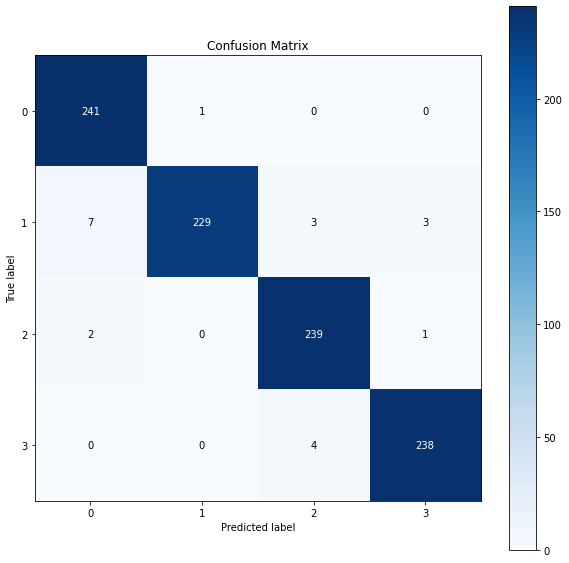

In [30]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(true_classes, predicted_classes)

plt.show()